## Contemporary Music Recommendation System using Historical Preferences

### Overview

Many of us who are at the age when AARP cards arrive in the mail are still listening to the music of our highschool and college days. Exposure to new music has diminished due to the decreased use of the radio as part of our daily routines.  Spotify, iTunes, Pandora, and other music apps provide a plethora of music options, and they make recommendations for other music based on a playlist, but most often those recommendations are of the same time period and genre.  


#### Problem
Many of us would like to try new music, but don’t know where to start, and don’t have the patience or time to research or listen to new music as a hit or miss exercise.

#### Solution
My objective is to develop a recommendation system to highlight new songs and artists for listeners based on their  historical music preferences.

### References

I took inspiration, modeling tool suggestions, and, in some cases, actual code from the following sites.  These references are cited in the corresponding sections of this notebook. 

- **developer.spotify.com**
    - API endpoint and feature information
- **scikit-learn.org**
    - KMeans and Silhouette Score
    - Lasso regression
- **Towards Data Science**
    - Spotipy API extraction
    - K-Prototype Use Cases
- **pandas.pydata.org**
    - Changing series to an array
    - Referencing indeces
    - pd.get_dummies 

### Project Setup

#### Import Tools
In order to import, process, and build a model for song recommendations, I am importing the following tools, including those required for clustering and measuring the accuracy of recommendations: KMeans, KMode (for clustering categorical variables), PCA, Silhouette Score, and Cosine Distance 

In [529]:
import pandas as pd
import numpy as np
import io, sys, os, re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
import requests
from itertools import chain
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.neighbors import KernelDensity
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
from numpy.linalg import norm
from collections import defaultdict

#### Import Data

This project includes obtaining the album and track audio features of songs from the 80s and 90s. These songs were found by identifying Spotify playlists representing music of different genres from this timeframe.  

##### Establish connection to Spotify's API

In [459]:
import http.client

con = http.client.HTTPConnection('https://api.spotify.com', 80, timeout=-1)

print(con)

In [460]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util


In [461]:
# The following code passes credentials in order to access the Spotify API.  Credentials are stored 
# securely in a local file

with open("API.txt", encoding="utf-8-sig") as f:
    secret_ls = f.readlines()
    cid = secret_ls[0][:-1]
    secret = secret_ls[1]
        

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

#### Create and Clean Datasets 

 - **track_data** - A list is created (track_data) to store all of the album and audio features of each track in the .txt file
 - **data** - the data from track_data is appended to another list (data).  This allows for additional data to be appended to the file if more tracks are found for training the model without having to import the entire list which is time consuming  
 - **df** - the dataframe created by converting the list of track dictionaries (data) to a dataframe
 

##### Dictionaries created from Spotify's API

In [41]:
# Initialize track_data list

track_data = []

In [ ]:
## Note - if appending data do not delete the data list! 
data = []

In [209]:
with open("URL.txt") as g:
    for url in g:
        playlist_link = url
        playlist_URI = playlist_link.split("/")[-1].split("?")[0]
        
        for track in sp.playlist_tracks(playlist_URI)["items"]:
            #URI
            track_uri = track["track"]["uri"]
    
            #Track name
            track_name = track["track"]["name"]
    
            #Main Artist
            artist_uri = track["track"]["artists"][0]["uri"]
            artist_info = sp.artist(artist_uri)
    
            #Name, popularity, genre (the first 6 genres in alphabetical order)
            artist_name = track["track"]["artists"][0]["name"]
            artist_pop = artist_info["popularity"]
            artist_genre_1 = artist_info["genres"][0:1]
            artist_genre_2 = artist_info["genres"][1:2]
            artist_genre_3 = artist_info["genres"][2:3]
            artist_genre_4 = artist_info["genres"][3:4]
            artist_genre_5 = artist_info["genres"][4:5]
            artist_genre_6 = artist_info["genres"][5:6]
    
            #Album
            album = track["track"]["album"]["name"]
            album_date = track["track"]["album"]["release_date"]
    
            #Popularity of the track
            track_pop = track["track"]["popularity"]
    
            #Track features
            danceability = sp.audio_features(track_uri)[0]['danceability']
            acousticness = sp.audio_features(track_uri)[0]['acousticness']
            energy = sp.audio_features(track_uri)[0]['energy']
            instrumentalness = sp.audio_features(track_uri)[0]['instrumentalness']
            key = sp.audio_features(track_uri)[0]['key']
            liveness = sp.audio_features(track_uri)[0]['liveness']
            loudness = sp.audio_features(track_uri)[0]['loudness']
            mode = sp.audio_features(track_uri)[0]['mode']
            speechiness = sp.audio_features(track_uri)[0]['speechiness']
            tempo = sp.audio_features(track_uri)[0]['tempo']
            valence = sp.audio_features(track_uri)[0]['valence']
    
            #List of Dictionary and audio feature items
            track_data = [
                track_uri, 
                track_name, 
                artist_name, 
                artist_pop, 
                artist_genre_1, 
                artist_genre_2, 
                artist_genre_3,
                artist_genre_4, 
                artist_genre_5, 
                artist_genre_6, 
                album, 
                album_date, 
                danceability, 
                acousticness, 
                energy, 
                instrumentalness, 
                key, 
                liveness, 
                loudness, 
                mode, 
                speechiness, 
                tempo, 
                valence]
    
            #Append track_data to data list
            data.append(track_data)

KeyboardInterrupt: 

In [210]:
# Check for the number of records in data
len(data)

6408

###### Obtaining Albums for Artists in Playlist - OPTIONAL

In [ ]:
## The code below is creating a list to retain all of the albums for artists in the playlist data.  This is 
## using the spotify api

### OPTIONAL - Only required for getting more data ###

sp_albums = []

for artist in data:
    #Pull all of the artist's albums
    sp_albums.append(sp.artist_albums(artist_uri, album_type='album'))
    
sp_albums

In [206]:
# Check for the number of records in the albums dataset (sp_albums)
len(sp_albums)

554

In [156]:
#Store artist's albums' names' and uris in separate lists.  this will be used in the next section 
#to pull tracks for each album

album_names = []
album_uris = []
    
for i in range(len(sp_albums['items'])):
    album_names.append(sp_albums['items'][i]['name'])
    album_uris.append(sp_albums['items'][i]['uri'])
        
    album_names
    album_uris
    
print(album_uris)
print(album_names)

TypeError: list indices must be integers or slices, not str

In [ ]:
#Check the number of records in the album_names and la

len(album_names)
len(album_uris)


##### Convert Playlist Dictionary to Dataframe

In [212]:
# Convert dictionary (data) into pandas dataframe (df)
df = pd.DataFrame.from_dict(data)

##### Size and Shape of Dataframe

In [213]:
display(df.shape)
display(df.info)


(6408, 23)

<bound method DataFrame.info of                                         0                       1   \
0     spotify:track:1qPbGZqppFwLwcBC1JQ6Vr              Wonderwall   
1     spotify:track:31AOj9sFz2gM0O3hMARRBx      Losing My Religion   
2     spotify:track:57iDDD9N9tTWe75x6qhStw   Bitter Sweet Symphony   
3     spotify:track:1d6KS9GH06JAd19uiBy9IE  Ironic - 2015 Remaster   
4     spotify:track:5DiXcVovI0FcY2s0icWWUu               Mr. Jones   
...                                    ...                     ...   
6403  spotify:track:6Qyc6fS4DsZjB2mRW9DsQs                    Iris   
6404  spotify:track:7mnGQesk1TzQLzQ9bYWZPR           She's so High   
6405  spotify:track:2IZZqH4K02UIYg5EohpNHF                  Zombie   
6406  spotify:track:6kWJvPfC4DgUpRsXKNa9z9      All That She Wants   
6407  spotify:track:1A5V1sxyCLpKJezp75tUXn            Closing Time   

                     2   3                   4                             5   \
0                 Oasis  75        [beatlesque

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6408 entries, 0 to 6407
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       6408 non-null   object 
 1   1       6408 non-null   object 
 2   2       6408 non-null   object 
 3   3       6408 non-null   int64  
 4   4       6408 non-null   object 
 5   5       6408 non-null   object 
 6   6       6408 non-null   object 
 7   7       6408 non-null   object 
 8   8       6408 non-null   object 
 9   9       6408 non-null   object 
 10  10      6408 non-null   object 
 11  11      6408 non-null   object 
 12  12      6408 non-null   float64
 13  13      6408 non-null   float64
 14  14      6408 non-null   float64
 15  15      6408 non-null   float64
 16  16      6408 non-null   int64  
 17  17      6408 non-null   float64
 18  18      6408 non-null   float64
 19  19      6408 non-null   int64  
 20  20      6408 non-null   float64
 21  21      6408 non-null   float64
 22  

In [215]:
# Update column headers

df.columns = ['track_uri', 
        'track_name', 
        'artist_name', 
        'artist_pop', 
        'artist_genre_1', 
        'artist_genre_2', 
        'artist_genre_3',
        'artist_genre_4', 
        'artist_genre_5', 
        'artist_genre_6', 
        'album', 
        'album_date', 
        'danceability', 
        'acousticness', 
        'energy', 
        'instrumentalness', 
        'key', 
        'liveness', 
        'loudness', 
        'mode', 
        'speechiness', 
        'tempo', 
        'valence']

##### Remove duplicate tracks from dataframe

Audio tracks may be duplicated across playlists.  As a result, the code below will identify duplicate entries and subsequently drop them from the file

In [216]:
df.drop_duplicates(subset = ['track_uri'], inplace = True)

In [219]:
# Check new number of records after removing duplicates

len(df)

4624

##### Format album data to datetime

In [220]:
# Convert album date to a date format
df['album_date'] = pd.to_datetime(df['album_date'])

In [221]:
df['album_date']

0      1995-10-02
1      1991-03-12
2      1997-09-29
3      1995-01-01
4      1993-01-01
          ...    
6389   2011-09-23
6390   1989-05-02
6391   2010-04-30
6392   2015-01-18
6393   2008-08-08
Name: album_date, Length: 4624, dtype: datetime64[ns]

In [222]:
df.head()

track_uri              track_name  \
0  spotify:track:1qPbGZqppFwLwcBC1JQ6Vr              Wonderwall   
1  spotify:track:31AOj9sFz2gM0O3hMARRBx      Losing My Religion   
2  spotify:track:57iDDD9N9tTWe75x6qhStw   Bitter Sweet Symphony   
3  spotify:track:1d6KS9GH06JAd19uiBy9IE  Ironic - 2015 Remaster   
4  spotify:track:5DiXcVovI0FcY2s0icWWUu               Mr. Jones   

         artist_name  artist_pop      artist_genre_1  \
0              Oasis          75        [beatlesque]   
1             R.E.M.          72  [alternative rock]   
2          The Verve          65  [alternative rock]   
3  Alanis Morissette          67      [canadian pop]   
4     Counting Crows          67  [alternative rock]   

                 artist_genre_2    artist_genre_3       artist_genre_4  \
0                     [britpop]      [madchester]     [permanent wave]   
1                [athens indie]  [permanent wave]           [pop rock]   
2                     [britpop]  [permanent wave]           [pop rock]   
3  [canadian singer-songwriter]        [pop rock]  [singer-songwriter]   
4                  [neo mellow]        [pop rock]               [rock]   

  artist_genre_5 artist_genre_6  ... acousticness energy  instrumentalness  \
0         [rock]             []  ...      0.00236  0.854          0.000000   
1         [rock]             []  ...      0.17900  0.855          0.000001   
2         [rock]     [shoegaze]  ...      0.03350  0.917          0.000000   
3             []             []  ...      0.21800  0.582          0.000000   
4             []             []  ...      0.18300  0.817          0.000003   

   key  liveness  loudness  mode  speechiness    tempo  valence  
0    2    0.1330    -5.609     1       0.0366  174.584    0.456  
1    9    0.0987    -5.051     0       0.0295  125.639    0.803  
2    9    0.4060    -6.006     1       0.0479  171.176    0.518  
3   11    0.1590    -8.305     1       0.0508  114.926    0.365  
4    0    0.2850    -6.542     1       0.0363  141.621    0.726  

[5 rows x 23 columns]

##### Convert artist genre columns from lists to string variables

In [223]:
#  As you can see above, the genre columns are still showing as lists.  The code below converts these to a string 
#  variable in the dataframe. 

df['artist_genre_1'] = df.artist_genre_1.apply(''.join)
df['artist_genre_2'] = df.artist_genre_2.apply(''.join)
df['artist_genre_3'] = df.artist_genre_3.apply(''.join)
df['artist_genre_4'] = df.artist_genre_4.apply(''.join)
df['artist_genre_5'] = df.artist_genre_5.apply(''.join)
df['artist_genre_6'] = df.artist_genre_6.apply(''.join)

In [224]:
# Check to confirm that the columns are now displaying correctly (with out brackets)
df.head()

track_uri              track_name  \
0  spotify:track:1qPbGZqppFwLwcBC1JQ6Vr              Wonderwall   
1  spotify:track:31AOj9sFz2gM0O3hMARRBx      Losing My Religion   
2  spotify:track:57iDDD9N9tTWe75x6qhStw   Bitter Sweet Symphony   
3  spotify:track:1d6KS9GH06JAd19uiBy9IE  Ironic - 2015 Remaster   
4  spotify:track:5DiXcVovI0FcY2s0icWWUu               Mr. Jones   

         artist_name  artist_pop    artist_genre_1  \
0              Oasis          75        beatlesque   
1             R.E.M.          72  alternative rock   
2          The Verve          65  alternative rock   
3  Alanis Morissette          67      canadian pop   
4     Counting Crows          67  alternative rock   

               artist_genre_2  artist_genre_3     artist_genre_4  \
0                     britpop      madchester     permanent wave   
1                athens indie  permanent wave           pop rock   
2                     britpop  permanent wave           pop rock   
3  canadian singer-songwriter        pop rock  singer-songwriter   
4                  neo mellow        pop rock               rock   

  artist_genre_5 artist_genre_6  ... acousticness energy  instrumentalness  \
0           rock                 ...      0.00236  0.854          0.000000   
1           rock                 ...      0.17900  0.855          0.000001   
2           rock       shoegaze  ...      0.03350  0.917          0.000000   
3                                ...      0.21800  0.582          0.000000   
4                                ...      0.18300  0.817          0.000003   

   key  liveness  loudness  mode  speechiness    tempo  valence  
0    2    0.1330    -5.609     1       0.0366  174.584    0.456  
1    9    0.0987    -5.051     0       0.0295  125.639    0.803  
2    9    0.4060    -6.006     1       0.0479  171.176    0.518  
3   11    0.1590    -8.305     1       0.0508  114.926    0.365  
4    0    0.2850    -6.542     1       0.0363  141.621    0.726  

[5 rows x 23 columns]

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4624 entries, 0 to 6393
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   track_uri         4624 non-null   object        
 1   track_name        4624 non-null   object        
 2   artist_name       4624 non-null   object        
 3   artist_pop        4624 non-null   int64         
 4   artist_genre_1    4624 non-null   object        
 5   artist_genre_2    4624 non-null   object        
 6   artist_genre_3    4624 non-null   object        
 7   artist_genre_4    4624 non-null   object        
 8   artist_genre_5    4624 non-null   object        
 9   artist_genre_6    4624 non-null   object        
 10  album             4624 non-null   object        
 11  album_date        4624 non-null   datetime64[ns]
 12  danceability      4624 non-null   float64       
 13  acousticness      4624 non-null   float64       
 14  energy            4624 n

##### Export df to a csv for safe keeping

In [226]:
import csv

df.to_csv('df.csv', index = True)

### Exploratory Data Analysis

#### Distributions

In [227]:
df.describe()

artist_pop  danceability  acousticness       energy  instrumentalness  \
count  4624.000000   4624.000000   4624.000000  4624.000000       4624.000000   
mean     57.208478      0.634329      0.150943     0.710391          0.075204   
std      15.970643      0.163652      0.202379     0.194736          0.204654   
min       0.000000      0.062100      0.000001     0.017400          0.000000   
25%      49.000000      0.535000      0.009173     0.578750          0.000001   
50%      60.000000      0.651000      0.062000     0.739000          0.000122   
75%      68.000000      0.752000      0.213000     0.870000          0.010700   
max      90.000000      0.988000      0.991000     0.999000          0.987000   

               key     liveness     loudness         mode  speechiness  \
count  4624.000000  4624.000000  4624.000000  4624.000000  4624.000000   
mean      5.398356     0.183059    -8.375951     0.656358     0.074737   
std       3.629864     0.151821     3.394596     0.474975     0.077230   
min       0.000000     0.011600   -27.547000     0.000000     0.022400   
25%       2.000000     0.081875   -10.491250     0.000000     0.033800   
50%       6.000000     0.125000    -7.798500     1.000000     0.044950   
75%       9.000000     0.252000    -5.871750     1.000000     0.075400   
max      11.000000     0.986000    -0.140000     1.000000     0.944000   

             tempo      valence  
count  4624.000000  4624.000000  
mean    120.921521     0.620035  
std      25.713339     0.240919  
min      58.396000     0.032600  
25%     102.317500     0.441000  
50%     119.836500     0.656000  
75%     133.279000     0.820000  
max     208.571000     0.982000

The distribution of acousticness, speechiness, and instrumentalness are not normally distributed.  Note: Mode is a binary variable

array([[<AxesSubplot:title={'center':'artist_pop'}>,
        <AxesSubplot:title={'center':'album_date'}>,
        <AxesSubplot:title={'center':'danceability'}>,
        <AxesSubplot:title={'center':'acousticness'}>],
       [<AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'instrumentalness'}>,
        <AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'liveness'}>],
       [<AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'mode'}>,
        <AxesSubplot:title={'center':'speechiness'}>,
        <AxesSubplot:title={'center':'tempo'}>],
       [<AxesSubplot:title={'center':'valence'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

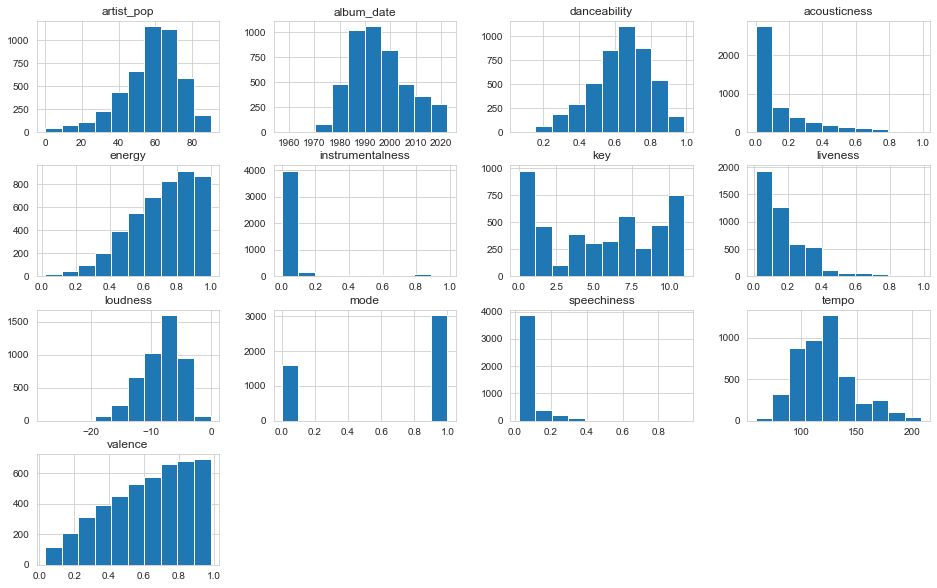

In [229]:
df.hist(figsize = (16,10))

#### Correlation Between Features

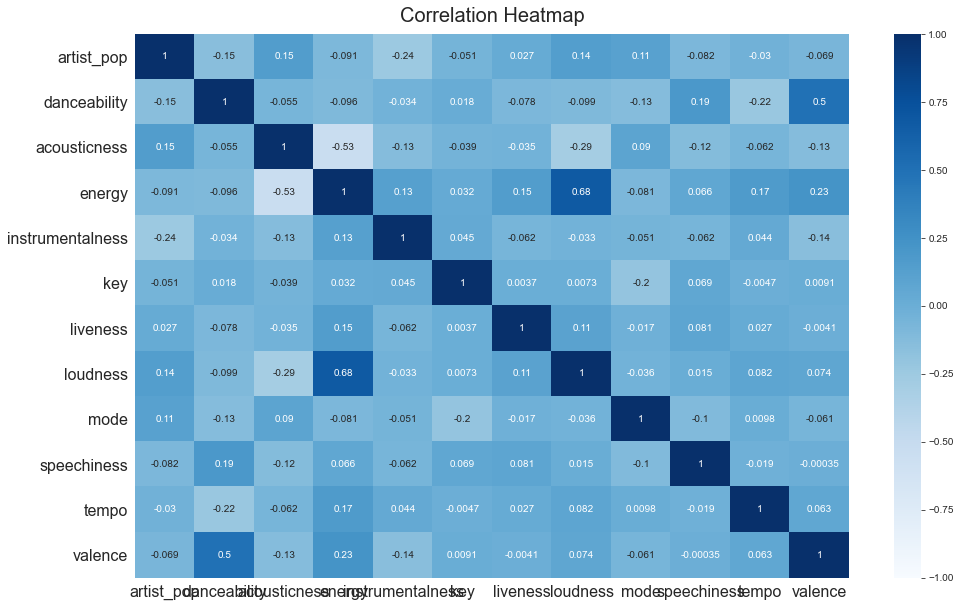

In [230]:
plt.figure(figsize = (16,10))
heatmap = sns.heatmap(df.corr(), annot=True, cmap='Blues',
           vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(),fontsize = 16)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(),fontsize = 16)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12);

### Clustering

### Create new dataframe for Clustering

- In order to keep df and the previous visuals in tact in case cells are rerun, a new dataframe is created for clustering exercises.  The new dataframe is **df_clusters**

In [231]:
df_clusters = df

#### Identify optimal numbers of clusters 

##### by caclulating Silhouette Score

- In order to calculate silhoutte score, PCA needs to be applied
- Prepare data for PCA by creating a dataframe including only numeric variables.  This dataframe is **X_num**
- Scale and fit, and transform the data for PCA by using the following pipeline. The output is a new dataframe **X_pca**

In [233]:
X_num = df_clusters.select_dtypes(np.number)

In [235]:
from sklearn.decomposition import PCA
pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X_num)
X_pca = pd.DataFrame(columns=['x', 'y'], data=song_embedding)

In [236]:
X_pca

x         y
0    -0.884125 -2.651721
1    -1.060224  0.241747
2    -1.463356 -2.477249
3     1.020922 -1.450013
4    -0.440150 -1.190690
...        ...       ...
4619 -0.943736  1.299872
4620 -1.888760  0.775696
4621 -0.656920  1.629731
4622 -0.204612  2.517199
4623 -0.586552  1.003433

[4624 rows x 2 columns]

###### The output of PCA (X_pca) is used as the input into the silhouette score analysis

For n_clusters = 2 The average silhouette_score is : 0.3740558072157595
For n_clusters = 3 The average silhouette_score is : 0.3736171033009553
For n_clusters = 4 The average silhouette_score is : 0.33112003855581706
For n_clusters = 5 The average silhouette_score is : 0.34633961302268507
For n_clusters = 6 The average silhouette_score is : 0.33385196595967276
For n_clusters = 7 The average silhouette_score is : 0.34067563242788906
For n_clusters = 8 The average silhouette_score is : 0.3326128432501479
For n_clusters = 9 The average silhouette_score is : 0.33318499582279065
For n_clusters = 10 The average silhouette_score is : 0.3295244043571618
For n_clusters = 11 The average silhouette_score is : 0.3288075507595352
For n_clusters = 12 The average silhouette_score is : 0.3332880741866704
For n_clusters = 13 The average silhouette_score is : 0.330028560636578
For n_clusters = 14 The average silhouette_score is : 0.3257964016693779
For n_clusters = 15 The average silhouette_score is : 0

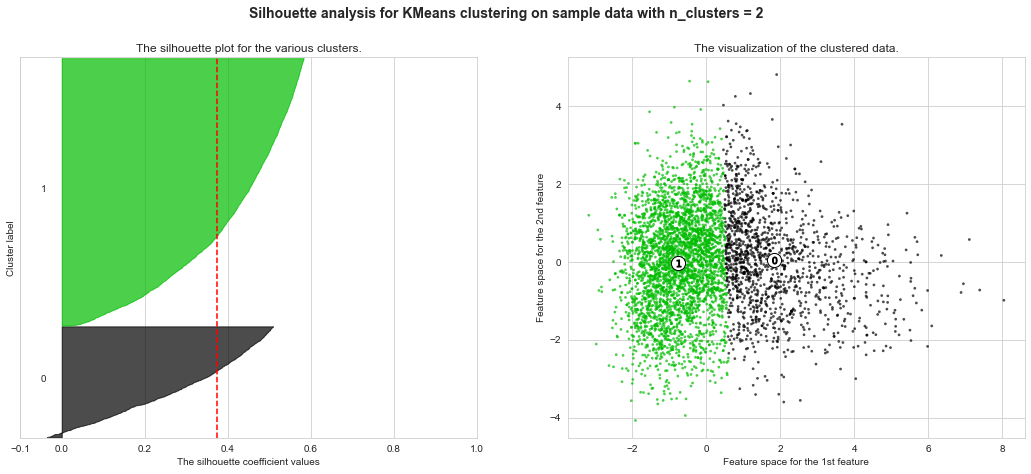

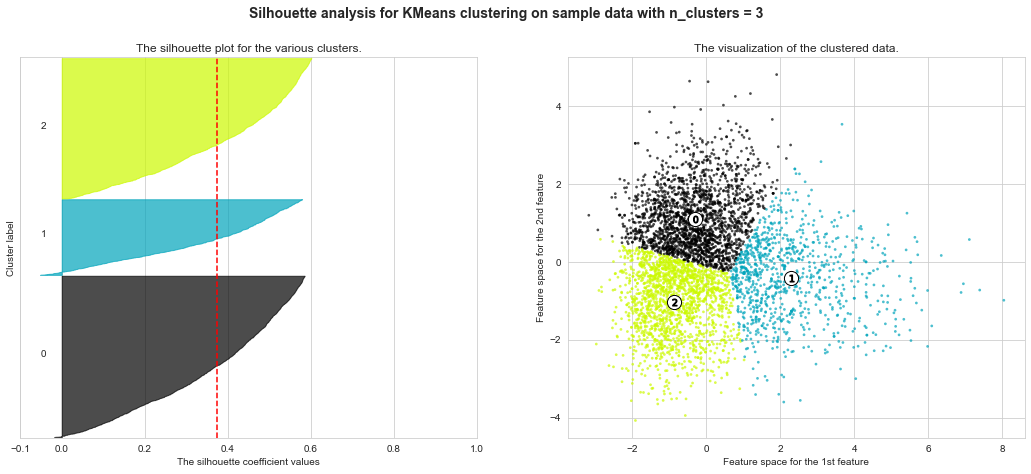

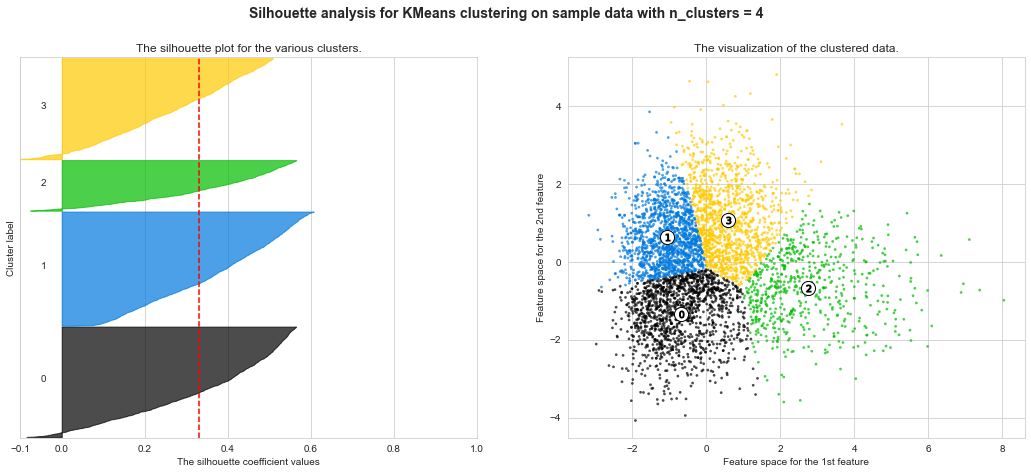

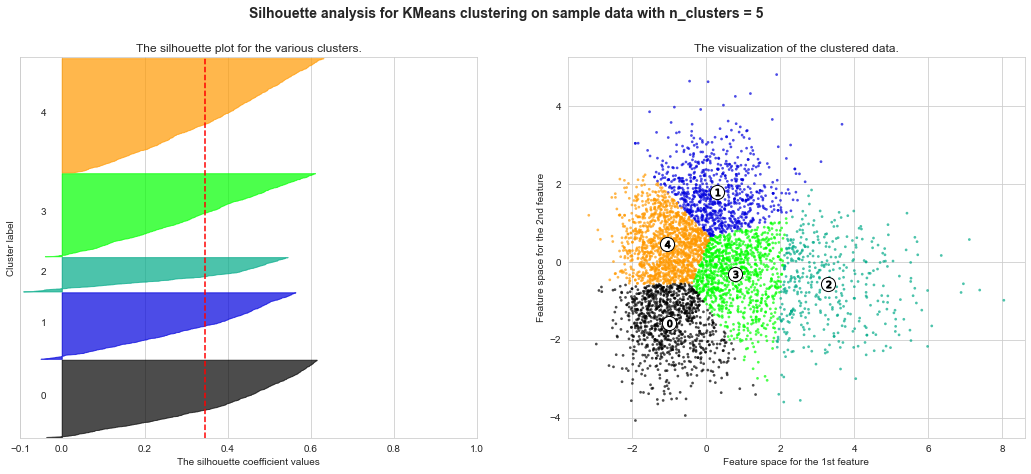

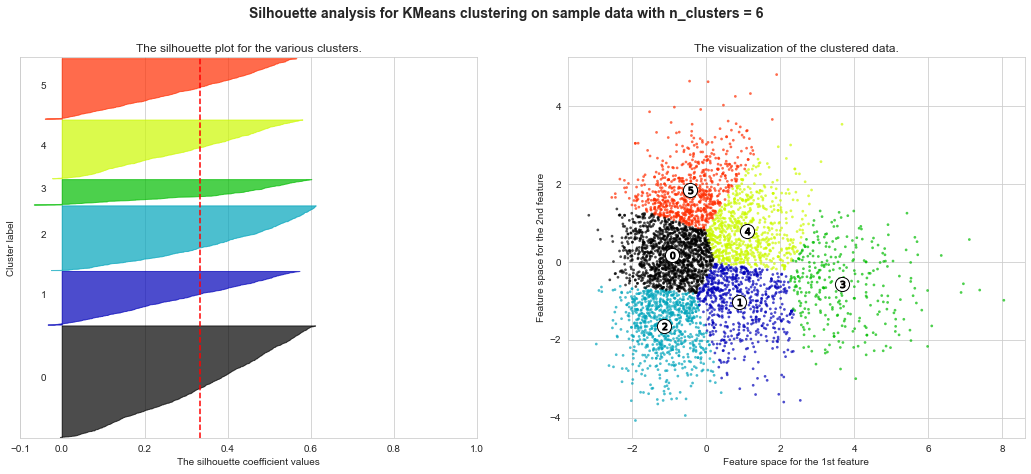

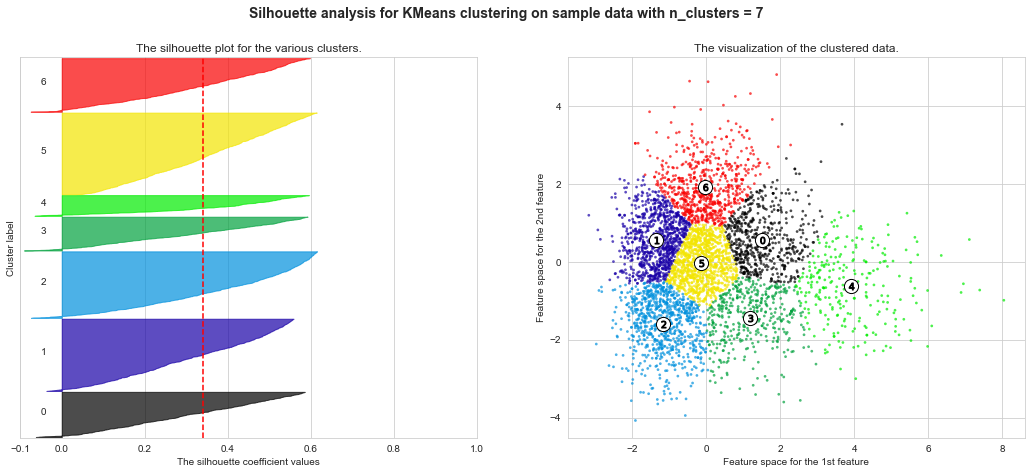

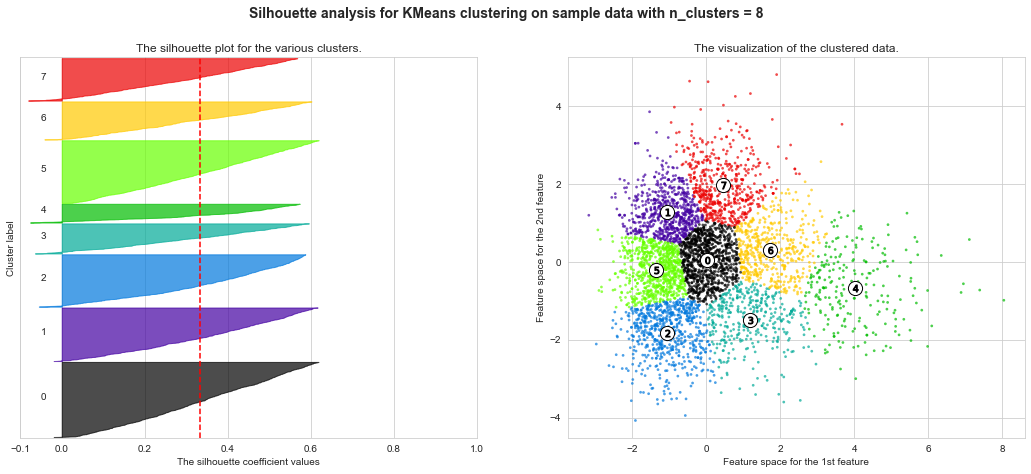

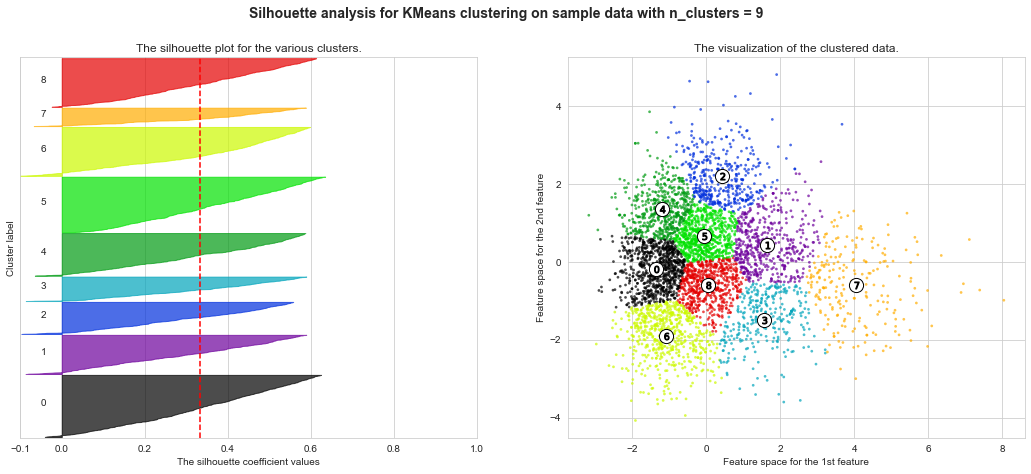

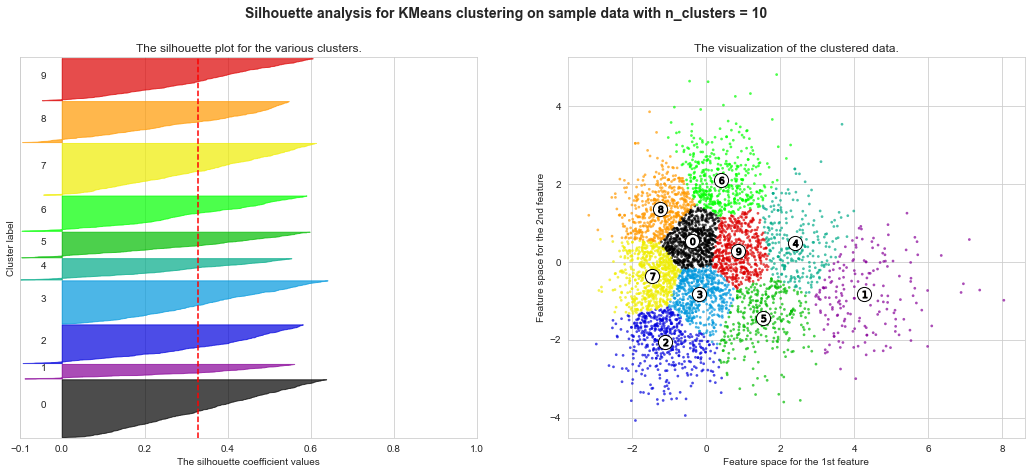

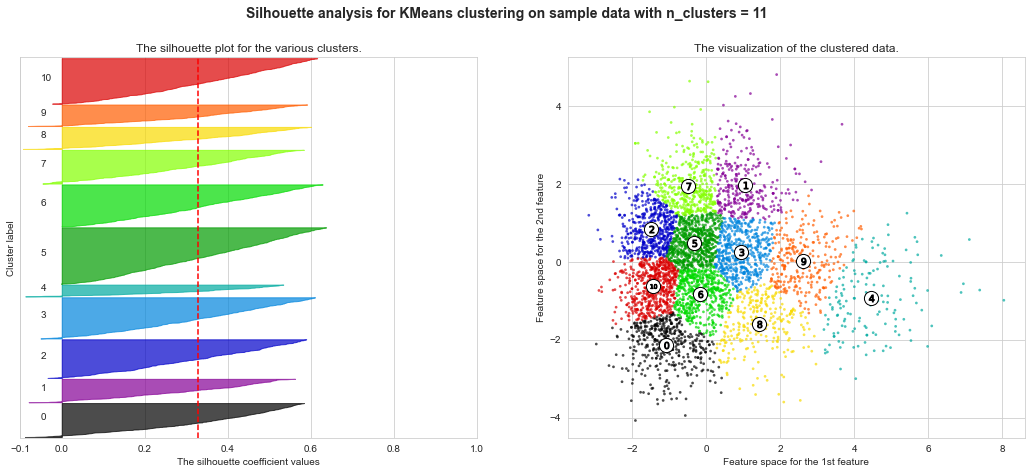

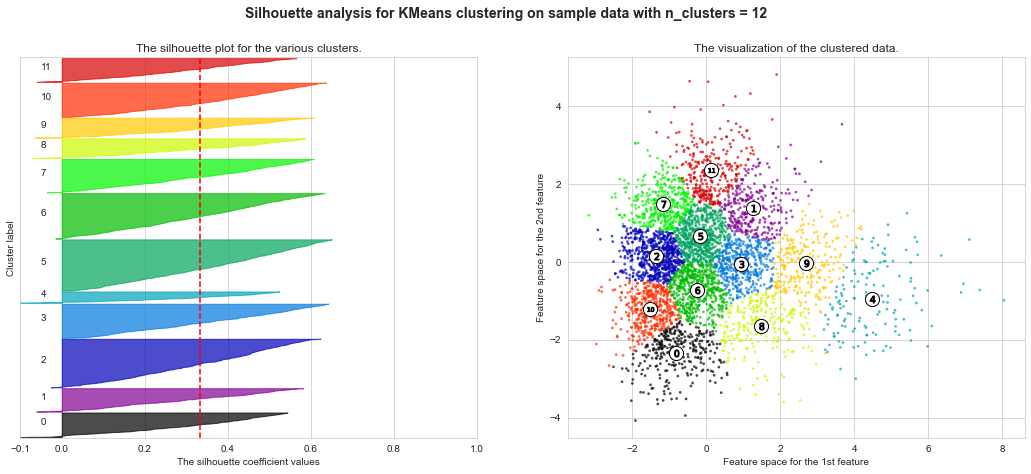

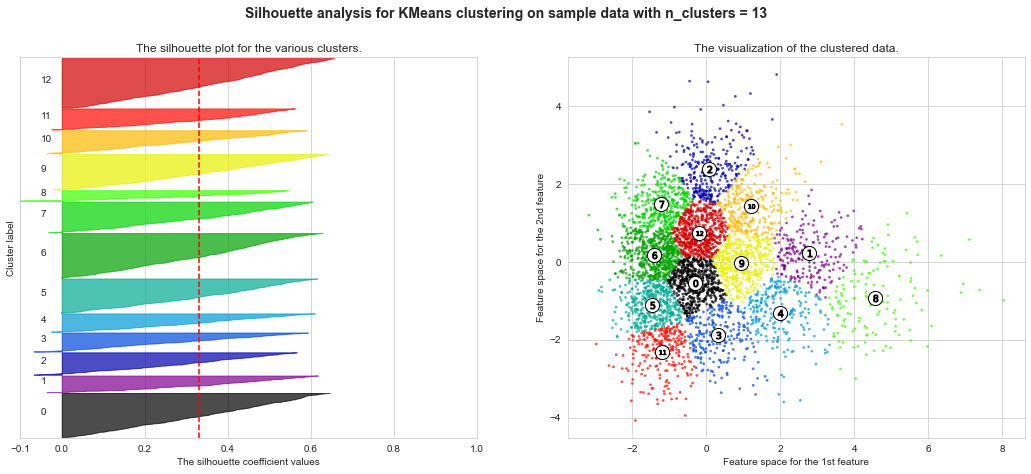

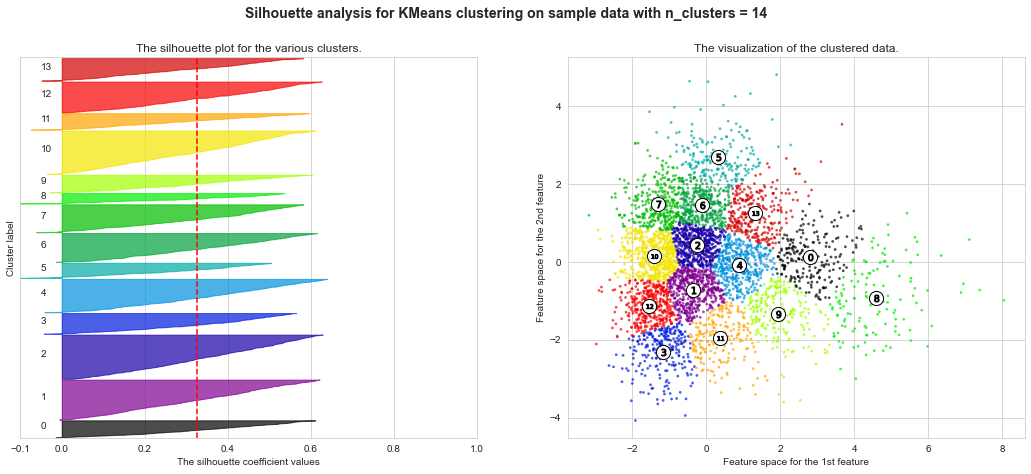

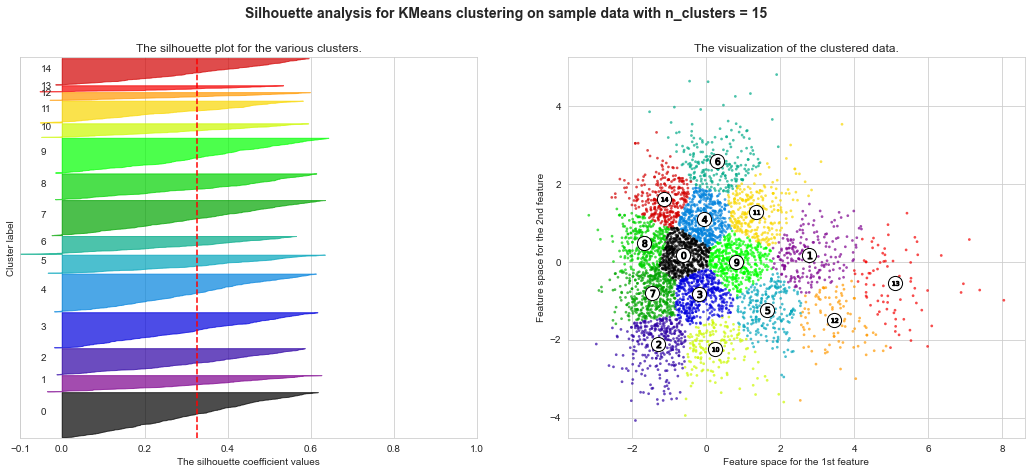

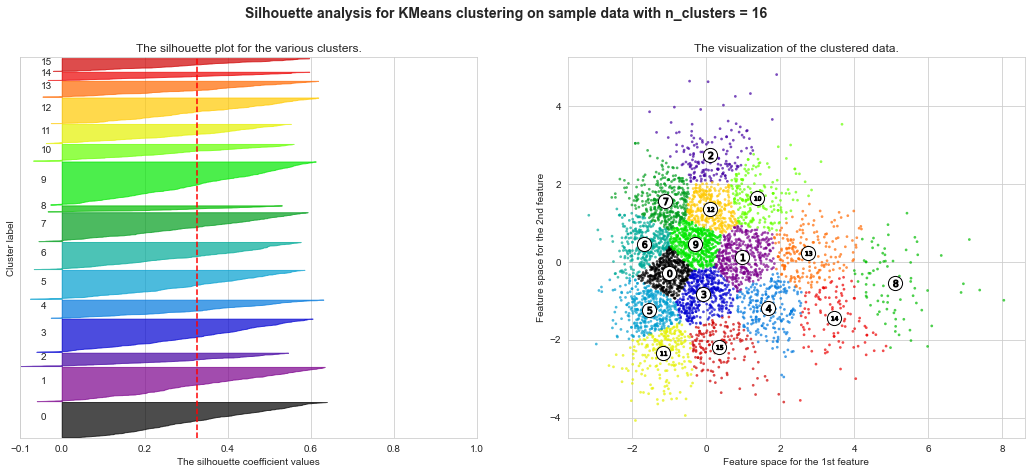

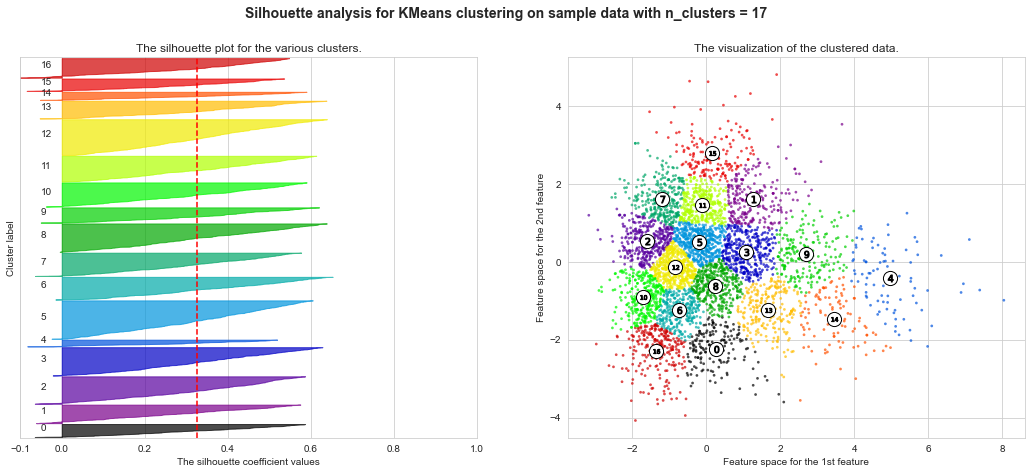

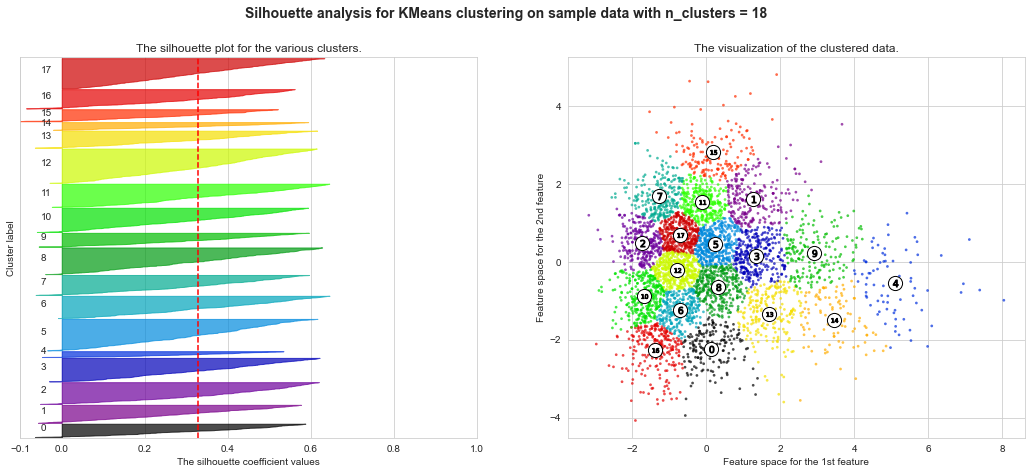

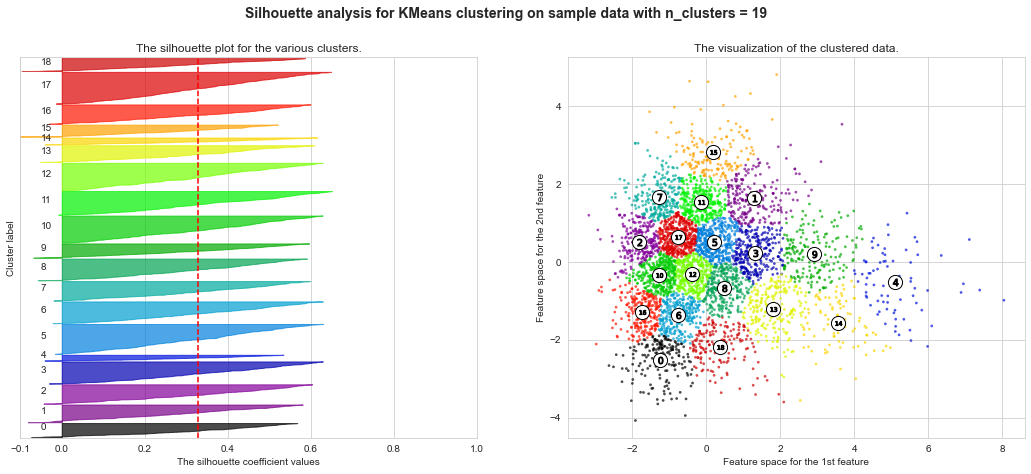

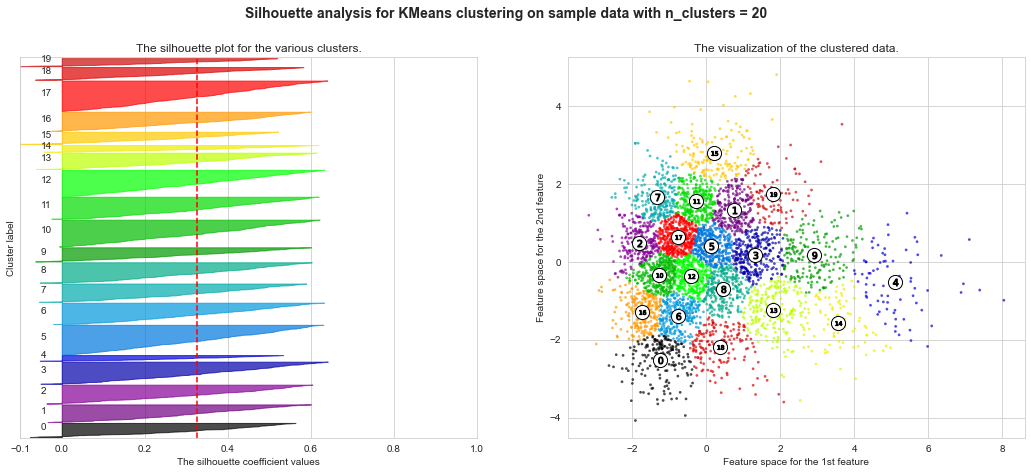

In [242]:
## Note: the code below is based on an example on scikit=learn.org
## https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis

%matplotlib inline
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_pca) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(X_pca)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_pca.iloc[:, 0], X_pca.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

##### by plotting inertia 

The code below will calculate the intertia at each cluster.  This will use a new version of the X_num dataset **X_num_inertia** since it will be scaled, fitted, and transformed again.  

Text(0.5, 1.0, 'Different Inertia Values for Number of Clusters 2 - 20')

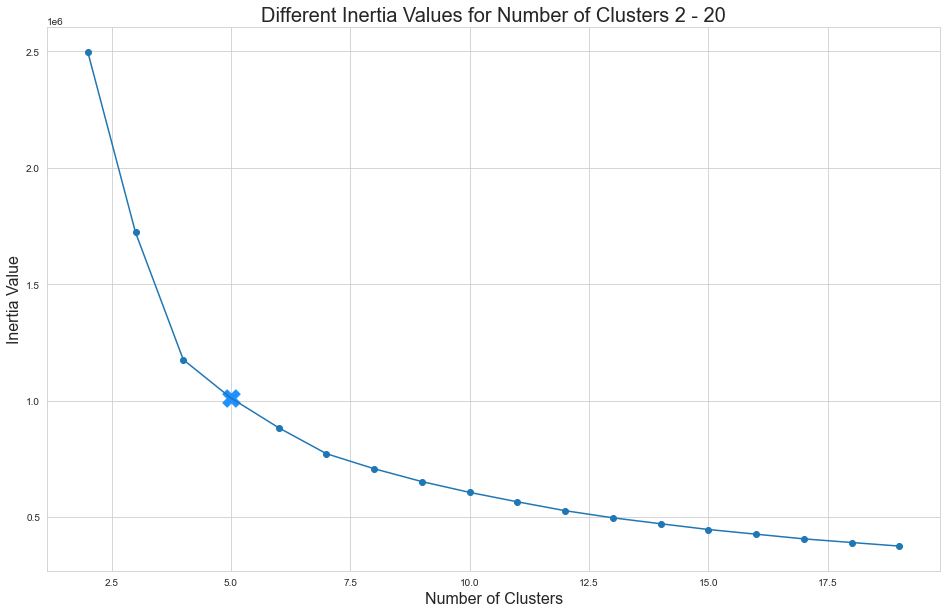

In [243]:
# Plotting Inertia
X_num_inertia = df_clusters.select_dtypes(np.number)

%matplotlib inline

## Reference plotting inertia article
plt.rcParams['figure.figsize'] = [16,10]
sns.set_style("whitegrid")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

inertia_list = []
for n in range(2, 20):
    kmeans_model = KMeans(n_clusters=n)
    kmeans_model.fit(X_num_inertia)
    inertia_list.append(kmeans_model.inertia_)
    
# plot the inertia curve
plt.plot(range(2,20),inertia_list)
plt.scatter(range(2,20),inertia_list)
plt.scatter(5, inertia_list[3], marker="X", s=300, c="dodgerblue")
plt.xlabel("Number of Clusters", size=16)
plt.ylabel("Inertia Value", size=16)
plt.title("Different Inertia Values for Number of Clusters 2 - 20", size=20)

#### Prepare data for clustering using KMeans

##### Now that we have identified the optimal number of clusters is 5, we can prepare the data to rerun KMeans with clusters = 5. 

- Create a dataframe containing only numeric variables from **df_clusters** which is different than X_num and X_pca in case these cells need to be rerun.  This dataset is **X_kmeans**
- X_kmeans will be scaled, fitted, and transformed for processing
- Create a list of the column names for the columns in X_kmeans.  This list is **number_cols**


In [250]:
cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                             ('kmeans', KMeans(n_clusters=5, n_init=10,
                             verbose=2))], verbose=True)

X_kmeans = df.select_dtypes(np.number)
number_cols = list(X_kmeans.columns)
cluster_pipeline.fit(X_kmeans)

cluster_labels = cluster_pipeline.predict(X_kmeans)



[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
Initialization complete
Iteration 0, inertia 63791.218933618795
Iteration 1, inertia 44539.55413968242
Iteration 2, inertia 42251.11005718574
Iteration 3, inertia 41061.38336176901
Iteration 4, inertia 40295.9777009244
Iteration 5, inertia 39180.695953043316
Iteration 6, inertia 38397.012287642574
Iteration 7, inertia 38348.11580089691
Iteration 8, inertia 38348.03919704633
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 59103.11922864187
Iteration 1, inertia 41610.67148366743
Iteration 2, inertia 40221.16709371575
Iteration 3, inertia 39511.66022388032
Iteration 4, inertia 39150.275009867524
Iteration 5, inertia 39133.634726800585
Iteration 6, inertia 39132.4886009175
Iteration 7, inertia 39131.51230431817
Iteration 8, inertia 39130.87929588916
Converged at iteration 8: center shift 5.317082730401253e-05 within tolerance 0.00010000000000000034.
Initialization complete
Iter

##### Create a new dataframe from df_clusters and add a new column for cluster labels

In [254]:
df_kmeans = df_clusters
df_kmeans['cluster_label'] = cluster_labels

df_kmeans.head()

track_uri              track_name  \
0  spotify:track:1qPbGZqppFwLwcBC1JQ6Vr              Wonderwall   
1  spotify:track:31AOj9sFz2gM0O3hMARRBx      Losing My Religion   
2  spotify:track:57iDDD9N9tTWe75x6qhStw   Bitter Sweet Symphony   
3  spotify:track:1d6KS9GH06JAd19uiBy9IE  Ironic - 2015 Remaster   
4  spotify:track:5DiXcVovI0FcY2s0icWWUu               Mr. Jones   

         artist_name  artist_pop    artist_genre_1  \
0              Oasis          75        beatlesque   
1             R.E.M.          72  alternative rock   
2          The Verve          65  alternative rock   
3  Alanis Morissette          67      canadian pop   
4     Counting Crows          67  alternative rock   

               artist_genre_2  artist_genre_3     artist_genre_4  \
0                     britpop      madchester     permanent wave   
1                athens indie  permanent wave           pop rock   
2                     britpop  permanent wave           pop rock   
3  canadian singer-songwriter        pop rock  singer-songwriter   
4                  neo mellow        pop rock               rock   

  artist_genre_5 artist_genre_6  ... energy instrumentalness  key  liveness  \
0           rock                 ...  0.854         0.000000    2    0.1330   
1           rock                 ...  0.855         0.000001    9    0.0987   
2           rock       shoegaze  ...  0.917         0.000000    9    0.4060   
3                                ...  0.582         0.000000   11    0.1590   
4                                ...  0.817         0.000003    0    0.2850   

   loudness  mode  speechiness    tempo  valence  cluster_label  
0    -5.609     1       0.0366  174.584    0.456              2  
1    -5.051     0       0.0295  125.639    0.803              2  
2    -6.006     1       0.0479  171.176    0.518              2  
3    -8.305     1       0.0508  114.926    0.365              0  
4    -6.542     1       0.0363  141.621    0.726              2  

[5 rows x 24 columns]

In [255]:
df_kmeans['cluster_label'].value_counts(normalize = True)

2    0.384732
4    0.267950
0    0.187284
3    0.081099
1    0.078936
Name: cluster_label, dtype: float64

In [256]:
df_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4624 entries, 0 to 6393
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   track_uri         4624 non-null   object        
 1   track_name        4624 non-null   object        
 2   artist_name       4624 non-null   object        
 3   artist_pop        4624 non-null   int64         
 4   artist_genre_1    4624 non-null   object        
 5   artist_genre_2    4624 non-null   object        
 6   artist_genre_3    4624 non-null   object        
 7   artist_genre_4    4624 non-null   object        
 8   artist_genre_5    4624 non-null   object        
 9   artist_genre_6    4624 non-null   object        
 10  album             4624 non-null   object        
 11  album_date        4624 non-null   datetime64[ns]
 12  danceability      4624 non-null   float64       
 13  acousticness      4624 non-null   float64       
 14  energy            4624 n

##### Visualizing the clusters

In [258]:
cluster_counts = df_kmeans['cluster_label'].value_counts()
cluster_counts


2    1779
4    1239
0     866
3     375
1     365
Name: cluster_label, dtype: int64

<AxesSubplot:>

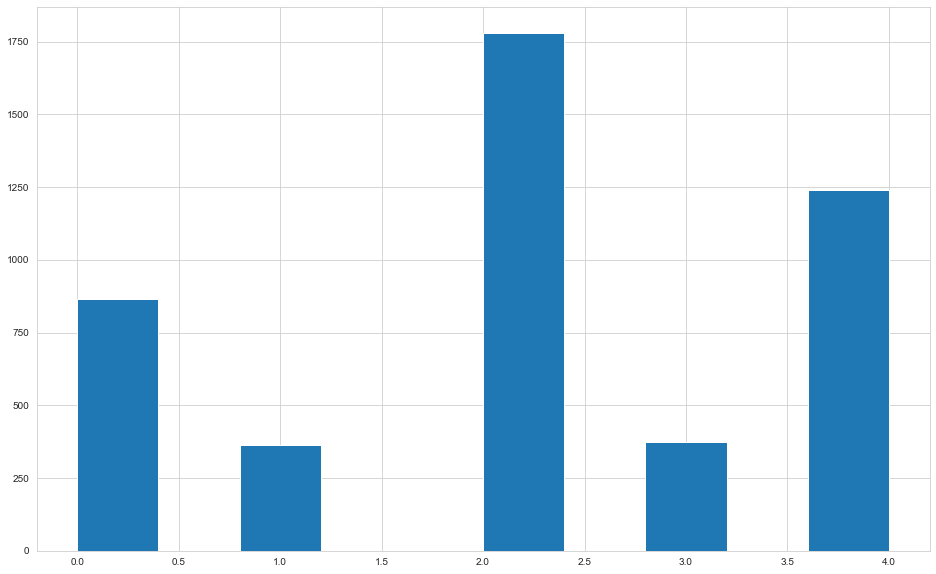

In [263]:
df_kmeans['cluster_label'].sort_values().hist()

##### Clusters and Genre

I have 5 clusters, but are these enough to make good recommendations in addition to audio features? How do they relate to artist_genre?  

The original dataframe contained up to 6 artist_genres assigned by Spotify for each track.  These were at a very granular level of detail.  The unique list of artist genres = 626.  I summarized these into 22.  If an artist had more than one genre, I applied a ranking system to choose only one genre.  This modified dataframe is **df_genre**

In [297]:
df_genre = pd.read_csv('df_genre.csv')

In [354]:
df_genre

Index                             track_uri  \
0         0  spotify:track:1qPbGZqppFwLwcBC1JQ6Vr   
1         1  spotify:track:31AOj9sFz2gM0O3hMARRBx   
2         2  spotify:track:57iDDD9N9tTWe75x6qhStw   
3         3  spotify:track:1d6KS9GH06JAd19uiBy9IE   
4         4  spotify:track:5DiXcVovI0FcY2s0icWWUu   
...     ...                                   ...   
4619   6389  spotify:track:5074Vt992hKDNhwXMhRceJ   
4620   6390  spotify:track:2AeelxeYAriGv9fHq1Fjsg   
4621   6391  spotify:track:7LvXGoyrWgYNywEC5s8awF   
4622   6392  spotify:track:2O3JCRH7IvUUbzbxEvoVAi   
4623   6393  spotify:track:5rzFkngmpxkgyNj0JlGvgB   

                                track_name        artist_name  artist_pop  \
0                               Wonderwall              Oasis          75   
1                       Losing My Religion             R.E.M.          72   
2                    Bitter Sweet Symphony          The Verve          65   
3                   Ironic - 2015 Remaster  Alanis Morissette          67   
4                                Mr. Jones     Counting Crows          67   
...                                    ...                ...         ...   
4619    Touch in the Night - Radio Version      Silent Circle          44   
4620                Too Many Broken Hearts      Jason Donovan          47   
4621                                  Ussr    Eddy Huntington          31   
4622                           High Energy      Evelyn Thomas          36   
4623  Telefone (Long Distance Love Affair)      Sheena Easton          55   

        artist_genre_1              artist_genre_2     artist_genre_3  \
0           beatlesque                     britpop         madchester   
1     alternative rock                athens indie     permanent wave   
2     alternative rock                     britpop     permanent wave   
3         canadian pop  canadian singer-songwriter           pop rock   
4     alternative rock                  neo mellow           pop rock   
...                ...                         ...                ...   
4619           europop               italian disco    new italo disco   
4620  australian dance              australian pop            europop   
4621     italian disco             new italo disco                NaN   
4622             disco                  diva house             hi-nrg   
4623   adult standards                 mellow gold  minneapolis sound   

         artist_genre_4 artist_genre_5  ... acousticness energy  \
0        permanent wave           rock  ...      0.00236  0.854   
1              pop rock           rock  ...      0.17900  0.855   
2              pop rock           rock  ...      0.03350  0.917   
3     singer-songwriter            NaN  ...      0.21800  0.582   
4                  rock            NaN  ...      0.18300  0.817   
...                 ...            ...  ...          ...    ...   
4619         spacesynth            NaN  ...      0.11400  0.731   
4620       new wave pop            NaN  ...      0.10400  0.966   
4621                NaN            NaN  ...      0.19600  0.814   
4622                NaN            NaN  ...      0.14300  0.765   
4623       new romantic   new wave pop  ...      0.24600  0.683   

     instrumentalness key liveness loudness mode  speechiness    tempo  \
0            0.000000   2   0.1330   -5.609    1       0.0366  174.584   
1            0.000001   9   0.0987   -5.051    0       0.0295  125.639   
2            0.000000   9   0.4060   -6.006    1       0.0479  171.176   
3            0.000000  11   0.1590   -8.305    1       0.0508  114.926   
4            0.000003   0   0.2850   -6.542    1       0.0363  141.621   
...               ...  ..      ...      ...  ...          ...      ...   
4619         0.021700   9   0.2800   -7.592    0       0.0328  123.088   
4620         0.000000   9   0.3570   -6.554    0       0.0440  122.214   
4621         0.011900   0   0.0348   -7.546    0       0.0316  110.457   
4622         0.046100 

In [299]:
df_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4624 entries, 0 to 6393
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   track_uri         4624 non-null   object        
 1   track_name        4624 non-null   object        
 2   artist_name       4624 non-null   object        
 3   artist_pop        4624 non-null   int64         
 4   artist_genre_1    4624 non-null   object        
 5   artist_genre_2    4624 non-null   object        
 6   artist_genre_3    4624 non-null   object        
 7   artist_genre_4    4624 non-null   object        
 8   artist_genre_5    4624 non-null   object        
 9   artist_genre_6    4624 non-null   object        
 10  album             4624 non-null   object        
 11  album_date        4624 non-null   datetime64[ns]
 12  danceability      4624 non-null   float64       
 13  acousticness      4624 non-null   float64       
 14  energy            4624 n

In [415]:
#The code below concatenates the new summary genre with the cluster labels in df_clusters

df_clusters_genres = df_genre.merge(df_clusters, on='track_uri')

df_clusters_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4624 entries, 0 to 4623
Data columns (total 61 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Index                   4624 non-null   int64         
 1   track_uri               4624 non-null   object        
 2   track_name_x            4624 non-null   object        
 3   artist_name_x           4624 non-null   object        
 4   artist_pop_x            4624 non-null   int64         
 5   artist_genre_1_x        4425 non-null   object        
 6   artist_genre_2_x        4164 non-null   object        
 7   artist_genre_3_x        3813 non-null   object        
 8   artist_genre_4_x        3158 non-null   object        
 9   artist_genre_5_x        2470 non-null   object        
 10  artist_genre_6_x        1817 non-null   object        
 11  Summary Genre1          4425 non-null   object        
 12  Summary Genre2          4162 non-null   object  

In [416]:
# The code below drops duplicate columns from the new dataframe

df_clusters_genres.drop(df_clusters_genres.iloc[:, 38:58],axis = 1, inplace=True)
df_clusters_genres.drop(['Index'], axis = 1, inplace=True)
df_clusters_genres.reset_index(drop=True, inplace=True)
df_clusters_genres

track_uri  \
0     spotify:track:1qPbGZqppFwLwcBC1JQ6Vr   
1     spotify:track:31AOj9sFz2gM0O3hMARRBx   
2     spotify:track:57iDDD9N9tTWe75x6qhStw   
3     spotify:track:1d6KS9GH06JAd19uiBy9IE   
4     spotify:track:5DiXcVovI0FcY2s0icWWUu   
...                                    ...   
4619  spotify:track:5074Vt992hKDNhwXMhRceJ   
4620  spotify:track:2AeelxeYAriGv9fHq1Fjsg   
4621  spotify:track:7LvXGoyrWgYNywEC5s8awF   
4622  spotify:track:2O3JCRH7IvUUbzbxEvoVAi   
4623  spotify:track:5rzFkngmpxkgyNj0JlGvgB   

                              track_name_x      artist_name_x  artist_pop_x  \
0                               Wonderwall              Oasis            75   
1                       Losing My Religion             R.E.M.            72   
2                    Bitter Sweet Symphony          The Verve            65   
3                   Ironic - 2015 Remaster  Alanis Morissette            67   
4                                Mr. Jones     Counting Crows            67   
...                                    ...                ...           ...   
4619    Touch in the Night - Radio Version      Silent Circle            44   
4620                Too Many Broken Hearts      Jason Donovan            47   
4621                                  Ussr    Eddy Huntington            31   
4622                           High Energy      Evelyn Thomas            36   
4623  Telefone (Long Distance Love Affair)      Sheena Easton            55   

      artist_genre_1_x            artist_genre_2_x   artist_genre_3_x  \
0           beatlesque                     britpop         madchester   
1     alternative rock                athens indie     permanent wave   
2     alternative rock                     britpop     permanent wave   
3         canadian pop  canadian singer-songwriter           pop rock   
4     alternative rock                  neo mellow           pop rock   
...                ...                         ...                ...   
4619           europop               italian disco    new italo disco   
4620  australian dance              australian pop            europop   
4621     italian disco             new italo disco                NaN   
4622             disco                  diva house             hi-nrg   
4623   adult standards                 mellow gold  minneapolis sound   

       artist_genre_4_x artist_genre_5_x artist_genre_6_x  ... key_x  \
0        permanent wave             rock              NaN  ...     2   
1              pop rock             rock              NaN  ...     9   
2              pop rock             rock         shoegaze  ...     9   
3     singer-songwriter              NaN              NaN  ...    11   
4                  rock              NaN              NaN  ...     0   
...                 ...              ...              ...  ...   ...   
4619         spacesynth              NaN              NaN  ...     9   
4620       new wave pop              NaN              NaN  ...     9   
4621                NaN              NaN              NaN  ...     0   
4622                NaN              NaN              NaN  ...    10   
4623       new romantic     new wave pop        soft rock  ...     9   

     liveness_x loudness_x mode_x speechiness_x  tempo_x  valence_x  tempo_y  \
0        0.1330     -5.609      1        0.0366  174.584      0.456  174.584   
1        0.0987     -5.051      0        0.0295  125.639      0.803  125.639   
2        0.4060     -6.006      1        0.0479  171.176      0.518  171.176   
3        0.1590     -8.305      1        0.0508  114.926      0.365  114.926   
4        0.2850     -6.542      1        0.0363  141.621      0.726  141.621   
...         ...        ...    ...           ...      ...        ...      ...   
4619     0.2800     -7.592      0        0.0328  123.088      0.924  123.088   
4620     0.3570     -6.554      0        0.0440  122.214      0.921  122.214   
4621     0.0348     -7.546      0        0.0316  110.457      0.972  

###### Distribution of genres across clusters

In [417]:
df_clusters_genres.groupby('cluster_label')['Main Artist Genre Name'].unique()

cluster_label
0    [Rock, Soul, Punk, Other, Reggae/Ska, Rap, Pop...
1    [Rock, Pop, EDM, nan, Other, Indie, Rap, Metal...
2    [Rock, Punk, Indie, Pop, Rap, Dance, Reggae/Sk...
3    [Rap, Hip Hop, nan, Rock, Latin, Reggae/Ska, P...
4    [Hip Hop, Indie, Rock, EDM, Rap, Latin, Pop, n...
Name: Main Artist Genre Name, dtype: object

Since we have 22 unique genres, there is definitely overlap across the clusters

It seems like the 5 clusters in combination genres may provide more detailed information to make predictions.  In order to do this, I need to cluster the data using categorical variables.  I can do this using KMode.  

KMode and KMeans can be combined using K-Prototype to cluster using both the numerical and categorical data.  

#### Create K-Prototype Clusters using K-Means and K-Mode

In order to use both categorical and continuous variables to create clusters, I am using the K-Mode clustering algorithm in addition to KMeans with K-Prototype

I referenced the following article when implementing K-Prototpye:

https://towardsdatascience.com/clustering-algorithm-for-data-with-mixed-categorical-and-numerical-features-d4e3a48066a0

***Preparing the data for K-Prototype:***

- Use df_clusters to create a new dataframe of numeric variables for this purpose. This dataframe is **X_num_proto**
- Remove unneeded columns (mode, artist popularity, and genre values)
- Scale values in dataframe
- Convert dataframe to array
- Make numeric variables float
- Create a dataframe including the necessary categorical variables from df_cluster.  This new dataframe is **df_proto**

In [356]:
#Scale values

X_num_proto = df_clusters.select_dtypes(np.number)
X_num_proto = X_num_proto.drop(['artist_pop', 'mode', 'cluster_label'], axis = 1

scaler = StandardScaler()
scaler.fit(X_num_proto)

X_num_proto


danceability  acousticness  energy  instrumentalness  key  liveness  \
0            0.410       0.00236   0.854          0.000000    2    0.1330   
1            0.666       0.17900   0.855          0.000001    9    0.0987   
2            0.356       0.03350   0.917          0.000000    9    0.4060   
3            0.408       0.21800   0.582          0.000000   11    0.1590   
4            0.578       0.18300   0.817          0.000003    0    0.2850   
...            ...           ...     ...               ...  ...       ...   
6389         0.707       0.11400   0.731          0.021700    9    0.2800   
6390         0.652       0.10400   0.966          0.000000    9    0.3570   
6391         0.737       0.19600   0.814          0.011900    0    0.0348   
6392         0.956       0.14300   0.765          0.046100   10    0.2500   
6393         0.844       0.24600   0.683          0.000002    9    0.1090   

      loudness  speechiness    tempo  valence  
0       -5.609       0.0366  174.584    0.456  
1       -5.051       0.0295  125.639    0.803  
2       -6.006       0.0479  171.176    0.518  
3       -8.305       0.0508  114.926    0.365  
4       -6.542       0.0363  141.621    0.726  
...        ...          ...      ...      ...  
6389    -7.592       0.0328  123.088    0.924  
6390    -6.554       0.0440  122.214    0.921  
6391    -7.546       0.0316  110.457    0.972  
6392   -12.772       0.0619  124.252    0.711  
6393    -4.292       0.0883  138.068    0.899  

[4624 rows x 10 columns]

In [359]:
X_num_proto.reset_index(drop=True, inplace=True)

In [426]:
# Create categorical variable dataframe: 

df_proto = df_clusters_genres[['track_uri','artist_name_x', 'Summary Genre1', 'Summary Genre2', 'Summary Genre3',
                                'Summary Genre4', 'Summary Genre5', 'Summary Genre6']]

# Updates Nans to "None"
df_proto = df_proto.astype(object).replace(np.nan, 'None')

In [427]:
df_proto

track_uri      artist_name_x  \
0     spotify:track:1qPbGZqppFwLwcBC1JQ6Vr              Oasis   
1     spotify:track:31AOj9sFz2gM0O3hMARRBx             R.E.M.   
2     spotify:track:57iDDD9N9tTWe75x6qhStw          The Verve   
3     spotify:track:1d6KS9GH06JAd19uiBy9IE  Alanis Morissette   
4     spotify:track:5DiXcVovI0FcY2s0icWWUu     Counting Crows   
...                                    ...                ...   
4619  spotify:track:5074Vt992hKDNhwXMhRceJ      Silent Circle   
4620  spotify:track:2AeelxeYAriGv9fHq1Fjsg      Jason Donovan   
4621  spotify:track:7LvXGoyrWgYNywEC5s8awF    Eddy Huntington   
4622  spotify:track:2O3JCRH7IvUUbzbxEvoVAi      Evelyn Thomas   
4623  spotify:track:5rzFkngmpxkgyNj0JlGvgB      Sheena Easton   

        Summary Genre1 Summary Genre2 Summary Genre3 Summary Genre4  \
0                Other            Pop          Other       New Wave   
1     Alternative Rock          Indie       New Wave           Rock   
2     Alternative Rock            Pop       New Wave           Rock   
3                  Pop          Other           Rock          Other   
4     Alternative Rock          Other           Rock           Rock   
...                ...            ...            ...            ...   
4619               Pop          Dance          Dance            EDM   
4620             Dance            Pop            Pop            Pop   
4621             Dance          Dance           None           None   
4622             Dance            EDM          Other           None   
4623             Other          Other          Other          Other   

     Summary Genre5 Summary Genre6  
0              Rock           None  
1              Rock           None  
2              Rock          Other  
3              None           None  
4              None           None  
...             ...            ...  
4619           None           None  
4620           None           None  
4621           None           None  
4622           None           None  
4623            Pop           Rock  

[4624 rows x 8 columns]

In [428]:
X_cat_num_proto = df_proto.join(X_num_proto)


In [762]:
# 2:

XKP_array[:,6] = XKP_array[:,6].astype(float)
XKP_array[:,11] = XKP_array[:,11].astype(float)x1
XKP_array[:,14] = XKP_array[:,14].astype(float)
XKP_array[:,19] = XKP_array[:,19].astype(float)


In [429]:
X_cat_num_proto = X_cat_num_proto.values

In [430]:
X_cat_num_proto

array([['spotify:track:1qPbGZqppFwLwcBC1JQ6Vr', 'Oasis', 'Other', ...,
        0.0366, 174.584, 0.456],
       ['spotify:track:31AOj9sFz2gM0O3hMARRBx', 'R.E.M.',
        'Alternative Rock', ..., 0.0295, 125.639, 0.803],
       ['spotify:track:57iDDD9N9tTWe75x6qhStw', 'The Verve',
        'Alternative Rock', ..., 0.0479, 171.176, 0.518],
       ...,
       ['spotify:track:7LvXGoyrWgYNywEC5s8awF', 'Eddy Huntington',
        'Dance', ..., 0.0316, 110.457, 0.972],
       ['spotify:track:2O3JCRH7IvUUbzbxEvoVAi', 'Evelyn Thomas', 'Dance',
        ..., 0.0619, 124.252, 0.711],
       ['spotify:track:5rzFkngmpxkgyNj0JlGvgB', 'Sheena Easton', 'Other',
        ..., 0.0883, 138.068, 0.899]], dtype=object)

In [431]:
## 3: Note that index range for categorical values is one higher than the index value in the array
cat_index = list(range(0,7))
cat_index

[0, 1, 2, 3, 4, 5, 6]

In [364]:
kproto = KPrototypes(n_clusters = 10, random_state = 42, n_init = 10)
kproto.fit_predict(X_cat_num_proto, categorical = cat_index)

array([6, 5, 6, ..., 3, 8, 2], dtype=uint16)

In [365]:
print(kproto.cost_)

599564.720220317


In [437]:
#new column for cluster labels associated with each subject

df_kproto_labels = df_proto

df_kproto_labels['kproto_labels'] = kproto.labels_
df_kproto_labels['acousticness'] = X_num_proto['acousticness']
df_kproto_labels['instrumentalness'] = X_num_proto['instrumentalness']
df_kproto_labels['loudness'] = X_num_proto['loudness']
df_kproto_labels['energy'] = X_num_proto['energy']
df_kproto_labels['valence'] = X_num_proto['valence']
df_kproto_labels['danceability'] = X_num_proto['danceability']
df_kproto_labels['speechiness'] = X_num_proto['speechiness']
df_kproto_labels['key'] = X_num_proto['key']
df_kproto_labels['tempo'] = X_num_proto['tempo']
df_kproto_labels['liveness'] = X_num_proto['liveness']

In [438]:
df_kproto_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4624 entries, 0 to 4623
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_uri         4624 non-null   object 
 1   artist_name_x     4624 non-null   object 
 2   Summary Genre1    4624 non-null   object 
 3   Summary Genre2    4624 non-null   object 
 4   Summary Genre3    4624 non-null   object 
 5   Summary Genre4    4624 non-null   object 
 6   Summary Genre5    4624 non-null   object 
 7   Summary Genre6    4624 non-null   object 
 8   kproto_labels     4624 non-null   uint16 
 9   acousticness      4624 non-null   float64
 10  instrumentalness  4624 non-null   float64
 11  loudness          4624 non-null   float64
 12  energy            4624 non-null   float64
 13  valence           4624 non-null   float64
 14  danceability      4624 non-null   float64
 15  speechiness       4624 non-null   float64
 16  key               4624 non-null   int64  


In [439]:
df_kproto_labels.groupby('kproto_labels')['Summary Genre1'].nunique()

kproto_labels
0    19
1    18
2    19
3    19
4    20
5    19
6    19
7    21
8    19
9    17
Name: Summary Genre1, dtype: int64

Even taking into account categorical variables, the kproto clusters still have a significant amount of overlap with genres

### Feature Importance

#### Random Forest Classifier

I have decided to use the random forest classifier to identify the features with the greatest importance.  I am using the kproto_label field as the y value and the remaining data as X.  

In [448]:
y = df_kproto_labels['kproto_labels']
X = df_kproto_labels.drop(['artist_name_x','Summary Genre1','Summary Genre2','Summary Genre3','Summary Genre4',\
                           'Summary Genre5', 'Summary Genre6','kproto_labels','track_uri'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4624 entries, 0 to 4623
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      4624 non-null   float64
 1   instrumentalness  4624 non-null   float64
 2   loudness          4624 non-null   float64
 3   energy            4624 non-null   float64
 4   valence           4624 non-null   float64
 5   danceability      4624 non-null   float64
 6   speechiness       4624 non-null   float64
 7   key               4624 non-null   int64  
 8   tempo             4624 non-null   float64
 9   liveness          4624 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 361.4 KB


In [449]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [450]:
X_train

acousticness  instrumentalness  loudness  energy  valence  danceability  \
3657       0.00894          0.839000    -7.273   0.833   0.7200         0.725   
178        0.07710          0.000000    -5.206   0.967   0.8950         0.712   
4145       0.00182          0.845000    -9.369   0.746   0.0354         0.677   
1652       0.08310          0.000000    -3.621   0.862   0.7420         0.932   
2197       0.01530          0.071700    -6.241   0.895   0.9320         0.673   
...            ...               ...       ...     ...      ...           ...   
4426       0.21600          0.006180    -4.560   0.749   0.9430         0.939   
466        0.02600          0.000007    -3.645   0.917   0.2060         0.349   
3092       0.43200          0.000006    -9.119   0.532   0.3410         0.601   
3772       0.39200          0.014100   -15.404   0.423   0.9600         0.908   
860        0.26500          0.012800    -7.629   0.510   0.9160         0.726   

      speechiness  key    tempo  liveness  
3657       0.0428    4  115.015    0.0915  
178        0.0470    7  145.024    0.3560  
4145       0.0385    7  126.016    0.0559  
1652       0.2460   10   95.244    0.3260  
2197       0.0317   10  127.053    0.1280  
...           ...  ...      ...       ...  
4426       0.0464    7  117.675    0.2900  
466        0.0710    0  164.036    0.0968  
3092       0.0286   10  136.571    0.0925  
3772       0.1020    0  103.653    0.2670  
860        0.0931    4   79.998    0.0788  

[3098 rows x 10 columns]

In [455]:
from sklearn.metrics import accuracy_score

RF=RandomForestClassifier(n_estimators=100)
RF.fit(X_train,y_train)
y_pred = RF.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.9187418086500655


In [456]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(n_jobs=1)

In [458]:
feature_imp = pd.Series(RF.feature_importances_)
feature_imp.sort_values(ascending = False).head(40)

8    0.636033
5    0.062114
6    0.050905
3    0.043563
4    0.041705
0    0.036963
2    0.035382
9    0.035183
1    0.033480
7    0.024672
dtype: float64

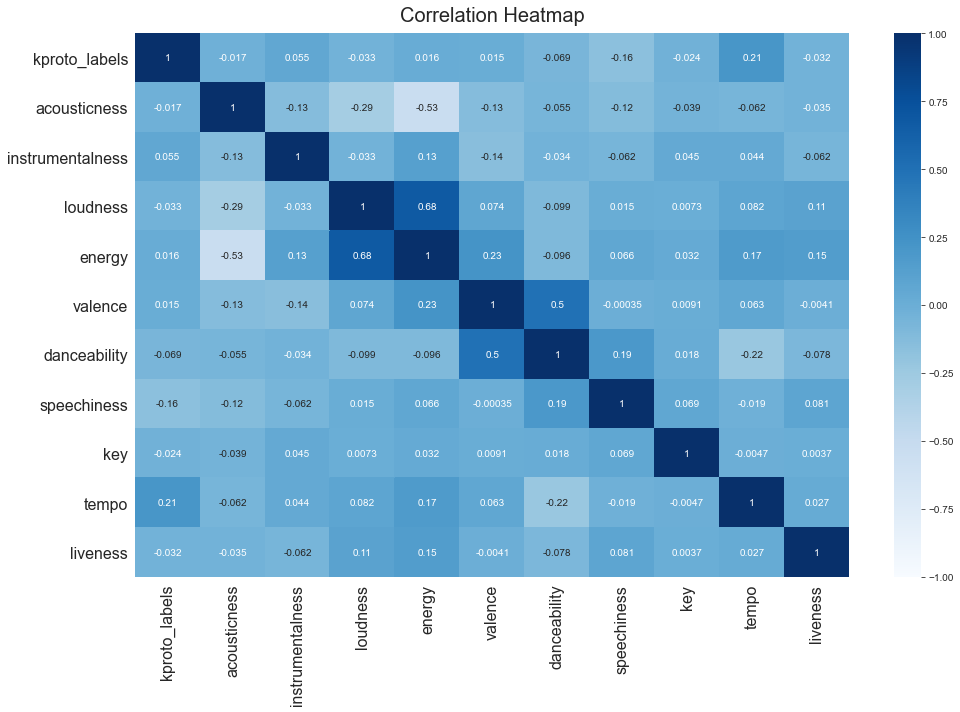

In [487]:
plt.figure(figsize = (16,10))
heatmap = sns.heatmap(df_kproto_labels.corr(), annot=True, cmap='Blues',
           vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(),fontsize = 16)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(),fontsize = 16)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12);

### Calculate Distance (Cosine)

In [548]:
comparison_song = df_kproto_labels[df_kproto_labels['track_uri'] == \
                                   'spotify:track:0ULPav7qqKTHn7vgi9v42k'].drop(['kproto_labels','artist_name_x', \
                                    'Summary Genre1','Summary Genre2','Summary Genre3','Summary Genre4',\
                                    'Summary Genre5','Summary Genre6'],axis=1)
comparison_song.set_index(['track_uri'], drop=True, inplace=True)
comparison_array = comparison_song.values
comparison_song.shape


(1, 10)

In [563]:
recommend_dataset = spotify_data[['id','acousticness','instrumentalness','loudness','energy','valence',\
                                 'danceability','speechiness','key','tempo','liveness']]
recommend_dataset.set_index(['id'],drop = True, inplace=True)
recommend_array = recommend_dataset.values
recommend_dataset.shape

(170653, 10)

In [536]:
# This code was written while referencing the following site: 
# https://www.geeksforgeeks.org/how-to-calculate-cosine-similarity-in-python/

# define two lists or arrays to compare
A = np.squeeze(np.asarray(recommend_array.select_dtypes(np.number)))
B = np.squeeze(np.asarray(comparison_array.select_dtypes(np.number)))
print("A:\n", A)
print("B:\n", B)
 
# compute cosine similarity
cosine = np.dot(A,B)/(norm(A, axis=1)*norm(B))
print("Cosine Similarity:\n", cosine)

AttributeError: 'numpy.ndarray' object has no attribute 'select_dtypes'

In [565]:
#recommend_dataset.shape

recommend_dataset['cos_sim'] = cosine_similarity(recommend_dataset, comparison_song).reshape(-1)

#recommend_dataset['cos_sim'] = recommend_dataset.apply(lambda _recommend_dataset: scipy.spatial.distance.cosine(_comparison_song, recommended_dataset))

<ipython-input-565-29b364c86b0c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Get Recommendations

#### Get Song Data for New Songs

In [470]:
## Import additional spotify data

spotify_data = pd.read_csv('spotify_data.csv')

In [475]:
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [ ]:
recommend_dataset = spotify_data[]

In [484]:
## The following code is based on a similar project published in Towards Data Science: 
## https://towardsdatascience.com/how-to-build-an-amazing-music-recommendation-system-4cce2719a572

def find_song(name, year):
  
    """
    This function returns a dataframe with data for a song given the name and release year.
    The function uses Spotipy to fetch audio features and metadata for the specified song.
    
    """
    
    song_data = defaultdict()
    results = sp.search(q= 'track: {} year: {}'.format(name,
                                                       year), limit=1)
    if results['tracks']['items'] == []:
        return None
    
    results = results['tracks']['items'][0]

    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]
    
    song_data['name'] = [name]
    song_data['year'] = [year]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]
    
    for key, value in audio_features.items():
        song_data[key] = value
    
    return pd.DataFrame(song_data)

In [ ]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=20, 
                                   verbose=2, n_jobs=4))],verbose=True)
X = spotify_data.select_dtypes(np.number)
number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
spotify_data['cluster_label'] = song_cluster_labels

In [472]:

from collections import defaultdict
from scipy.spatial.distance import cdist
import difflib

num_cols = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']

def get_song_data(song, spotify_data):
    
    """
    Gets the song data for a specific song. The song argument takes the form of a dictionary with 
    key-value pairs for the name and release year of the song.
    """
    
    try:
        song_data = spotify_data[(spotify_data['name'] == song['name']) 
                                & (spotify_data['year'] == song['year'])].iloc[0]
        return song_data
    
    except IndexError:
        return find_song(song['name'], song['year'])
        

def get_mean_vector(song_list, spotify_data):
    
    """
    Gets the mean vector for a list of songs.
    """
    
    song_vectors = []
    
    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        song_vector = song_data[number_cols].values
        song_vectors.append(song_vector)  
    
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)

def flatten_dict_list(dict_list):
   
    """
    Utility function for flattening a list of dictionaries.
    """
    
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
            
    return flattened_dict
        

def recommend_songs(song_list, spotify_data, n_songs=10):
  
    """
    Recommends songs based on a list of previous songs that a user has listened to.
    """
    
    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)
    
    song_center = get_mean_vector(song_list, spotify_data)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(spotify_data[num_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    
    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')

In [473]:
recommend_songs([{'name': 'Come As You Are', 'year':1991},
                {'name': 'Smells Like Teen Spirit', 'year': 1991},
                {'name': 'Lithium', 'year': 1992},
                {'name': 'All Apologies', 'year': 1993},
                {'name': 'Stay Away', 'year': 1993}],  spotify_data)

KeyError: "['artist_pop', 'cluster_label'] not in index"

In [832]:
df

track_uri  \
0     spotify:track:1qPbGZqppFwLwcBC1JQ6Vr   
1     spotify:track:31AOj9sFz2gM0O3hMARRBx   
2     spotify:track:57iDDD9N9tTWe75x6qhStw   
3     spotify:track:1d6KS9GH06JAd19uiBy9IE   
4     spotify:track:5DiXcVovI0FcY2s0icWWUu   
...                                    ...   
5907  spotify:track:7mH6hpO4UguvZPbrZhrYwR   
5908  spotify:track:5eFCFpmDbqGqpdOVE9CXCh   
5909  spotify:track:5bGlU4BXhMRMMHWZnHuKhj   
5910  spotify:track:5OiphBsPdIMIldVkx5VXJb   
5911  spotify:track:25cVyUYzONCdHUeFWKbOol   

                                          track_name          artist_name  \
0                                         Wonderwall                Oasis   
1                                 Losing My Religion               R.E.M.   
2                              Bitter Sweet Symphony            The Verve   
3                             Ironic - 2015 Remaster    Alanis Morissette   
4                                          Mr. Jones       Counting Crows   
...                                              ...                  ...   
5907                             Work It to the Bone                  LNR   
5908  That's the Way Love Is - Underground Mix; Edit             Ten City   
5909                                         Someday          CeCe Rogers   
5910                 You’re Gonna Miss Me - 1988 Mix  Turntable Orchestra   
5911                                    Acid Thunder           Fast Eddie   

      artist_pop    artist_genre_1              artist_genre_2  \
0             75        beatlesque                     britpop   
1             72  alternative rock                athens indie   
2             65  alternative rock                     britpop   
3             67      canadian pop  canadian singer-songwriter   
4             67  alternative rock                  neo mellow   
...          ...               ...                         ...   
5907          15                                                 
5908          34     chicago house               classic house   
5909          39     classic house                               
5910           5      garage house                               
5911          31        acid house               chicago house   

      artist_genre_3     artist_genre_4 artist_genre_5 artist_genre_6  ...  \
0         madchester     permanent wave           rock                 ...   
1     permanent wave           pop rock           rock                 ...   
2     permanent wave           pop rock           rock       shoegaze  ...   
3           pop rock  singer-songwriter                                ...   
4           pop rock               rock                                ...   
...              ...                ...            ...            ...  ...   
5907                                                                   ...   
5908      deep house          hip house    vocal house                 ...   
5909                                                                   ...   
5910                                                                   ...   
5911     chicago rap      classic house      hip house                 ...   

     instrumentalness  key  liveness  loudness  mode  speechiness    tempo  \
0            0.000000    2    0.1330    -5.609     1       0.0366  174.584   
1            0.000001    9    0.0987    -5.051     0       0.0295  125.639   
2            0.000000    9    0.4060    -6.006     1       0.0479  171.176   
3            0.000000   11    0.1590    -8.305     1       0.0508  114.926   
4            0.000003    0    0.2850    -6.542     1       0.0363  141.621   
...               ...  ...       ...       ...   ...          ...      ...   
5907         0.105000    1    0.0430    -6.011     1       0.0588  122.833   
5908         0.000095    7    0.0762   -11.421     1       0.0485  120.772   
5909         0.000240    9    0.0415   -15.149     0       0.0520  119.582   
5910         0.344000    1    0.2190    -7.46